1. Dataset Preparation and Preprocessing:

In [ ]:
import zipfile
import os

# Assuming file is in your current working directory
zip_path = "/content/Copy of devnagari digit.zip"
extract_path = "/content/DevnagariDataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")


✅ Dataset extracted!


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
# Load all images from your dataset folder (assumed extracted)
data_dir = "/content/DevnagariDataset/DevanagariHandwrittenDigitDataset/Train"  # Update if path differs
images = []

# Traverse each class folder (0-9 digits assumed)
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".png"):
                img_path = os.path.join(folder_path, file)
                img = Image.open(img_path).convert("L").resize((32, 32))  # Resize and grayscale
                img_array = np.array(img)
                images.append(img_array)

# Convert list to NumPy array and normalize
images = np.array(images).astype("float32") / 255.0  # Normalize to [0, 1]

# Reshape for Keras: (samples, height, width, channels)
images = images.reshape(-1, 32, 32, 1)

# Split into training and validation sets
x_train, x_val = train_test_split(images, test_size=0.2, random_state=42)

# Add Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

# Clip values to maintain range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)


2. Build the Denoising Convolutional Autoencoder:


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Input Layer
input_img = Input(shape=(32, 32, 1))

# Encoder (2 Convolutional + MaxPooling layers)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # Output size: 8x8x64

# Decoder (2 Convolutional + Upsampling layers)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Output Layer with sigmoid for pixel values in [0,1]
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define and compile the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')  # Loss suited for [0, 1] images
autoencoder.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

3. Train the Denoising Autoencoder:


In [ ]:
# Train the model using noisy images as input, and original images as target
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,   # Can be 64 or 128, depending on system memory
    shuffle=True,
    validation_data=(x_val_noisy, x_val)
)


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 516ms/step - loss: 0.3938 - val_loss: 0.1853
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 501ms/step - loss: 0.1795 - val_loss: 0.1765
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - loss: 0.1690 - val_loss: 0.1652
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 508ms/step - loss: 0.1636 - val_loss: 0.1608
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - loss: 0.1607 - val_loss: 0.1589
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 465ms/step - loss: 0.1582 - val_loss: 0.1586
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 52s 491ms/step - loss: 0.1571 - val_loss: 0.1555
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 476ms/step - loss: 0.1552 - val_loss: 0.1542
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 478ms/step - loss: 0.1542 - val_loss: 0.1594
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 52s 488ms/step - loss: 0.1554 - val_loss: 0.1523
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - loss: 0.1519 - val_loss: 0.1523
Epoch 12/20
107/107

4. Evaluate and Visualize the Results:


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


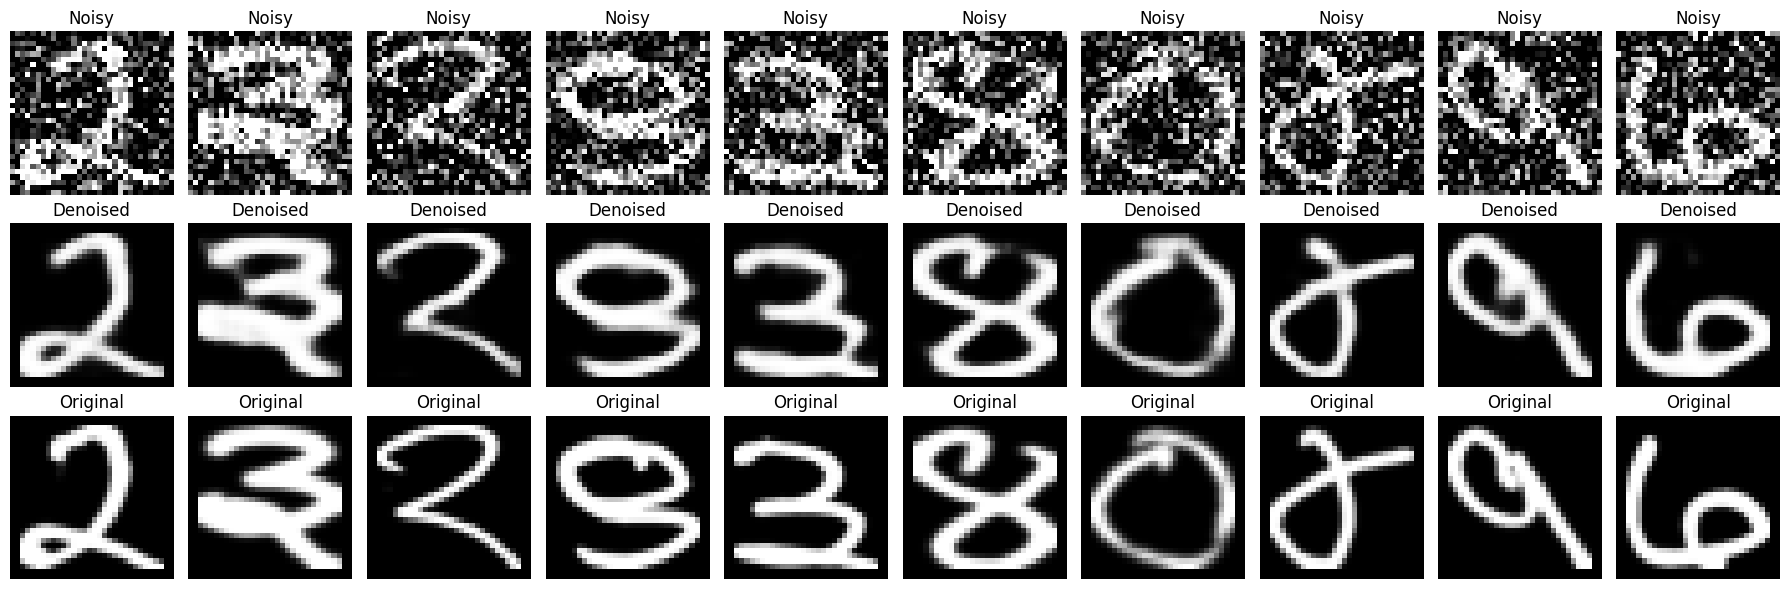

In [ ]:
# Use the trained model to denoise validation images
denoised_imgs = autoencoder.predict(x_val_noisy)

# Visualize: Noisy | Denoised | Original
n = 10  # number of images to display
plt.figure(figsize=(18, 6))
for i in range(n):
    # Display noisy image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(32, 32), cmap="gray")
    plt.title("Noisy")
    plt.axis('off')

    # Display denoised image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_imgs[i].reshape(32, 32), cmap="gray")
    plt.title("Denoised")
    plt.axis('off')

    # Display original image
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_val[i].reshape(32, 32), cmap="gray")
    plt.title("Original")
    plt.axis('off')
plt.tight_layout()
plt.show()
